# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import helper

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

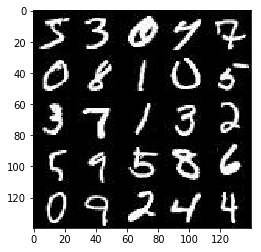

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

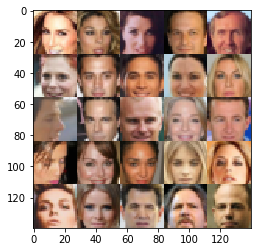

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, shape=[None, z_dim], name='fake_inputs')
    learning_rate = tf.placeholder(tf.float32)
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input layer is 28 x 28 x 3
        
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * h1, h1)
        # 14 x 14 x 64
        
        h2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        # logits
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits =  tf.layers.dense(flat, 1)
        
        # output 
        out = tf.nn.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """  
    # TODO: Implement Function 
    with tf.variable_scope("generator", reuse=(not is_train)):
 
        # First fully connected layer
        h0 = tf.layers.dense(z, 3*3*256)  
        
        #  # First fully connected layer 
        h0 = tf.reshape(h0, (-1, 3, 3, 256))
        h0 = tf.layers.batch_normalization(h0, training=is_train)
        h0 = tf.maximum(alpha * h0, h0)
        # 4 x 4 x 256 now
        
        # first convolutional layer
        h1 = tf.layers.conv2d_transpose(h0, filters=128, kernel_size=3, strides=2, padding='valid')
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 7 x 7 x 128 now
        
        # second convolutional layer
        h2 = tf.layers.conv2d_transpose(h1, filters=64, kernel_size=5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 14 x 14 x 64 now
        
        h3 = tf.layers.conv2d_transpose(h2, filters=32, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        # 28 x 28 x 32 now        
        
        # Output layer  
        logits = tf.layers.conv2d_transpose(h3, filters=out_channel_dim, kernel_size=5, strides=1, padding='same')
        # 28 x 28 x 3 now
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # label smoothing
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # updating batch normalization
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(image_width=data_shape[1], 
                                                   image_height=data_shape[2], 
                                                   image_channels=data_shape[3], 
                                                   z_dim=z_dim)

    d_loss, g_loss = model_loss(input_real, 
                                input_z, 
                                data_shape[3])

    d_opt, g_opt = model_opt(d_loss, 
                             g_loss, 
                             learn_rate, 
                             beta1)    
    
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #rescale batch image samples to get them in range -1, 1
                batch_images = batch_images * 2                
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               input_real: batch_images,
                                               learn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:    
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  

            # at the end of every epoch show generator output   
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.2466... Generator Loss: 0.7290
Epoch 1/2... Batch 20... Discriminator Loss: 0.9807... Generator Loss: 1.3901
Epoch 1/2... Batch 30... Discriminator Loss: 0.9388... Generator Loss: 1.2615
Epoch 1/2... Batch 40... Discriminator Loss: 1.3321... Generator Loss: 0.8620
Epoch 1/2... Batch 50... Discriminator Loss: 1.2491... Generator Loss: 0.9450
Epoch 1/2... Batch 60... Discriminator Loss: 1.1862... Generator Loss: 0.9250
Epoch 1/2... Batch 70... Discriminator Loss: 1.2375... Generator Loss: 1.1000
Epoch 1/2... Batch 80... Discriminator Loss: 1.2009... Generator Loss: 1.0463
Epoch 1/2... Batch 90... Discriminator Loss: 1.2276... Generator Loss: 0.9261
Epoch 1/2... Batch 100... Discriminator Loss: 1.1592... Generator Loss: 0.9278


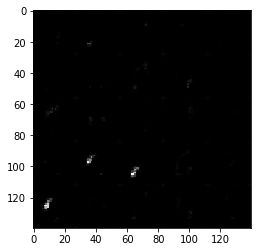

Epoch 1/2... Batch 110... Discriminator Loss: 1.2207... Generator Loss: 0.7792
Epoch 1/2... Batch 120... Discriminator Loss: 1.1822... Generator Loss: 0.7926
Epoch 1/2... Batch 130... Discriminator Loss: 1.1967... Generator Loss: 0.8189
Epoch 1/2... Batch 140... Discriminator Loss: 1.2571... Generator Loss: 0.8778
Epoch 1/2... Batch 150... Discriminator Loss: 1.2318... Generator Loss: 1.0712
Epoch 1/2... Batch 160... Discriminator Loss: 1.1450... Generator Loss: 1.0023
Epoch 1/2... Batch 170... Discriminator Loss: 1.2854... Generator Loss: 1.0064
Epoch 1/2... Batch 180... Discriminator Loss: 1.2776... Generator Loss: 0.9834
Epoch 1/2... Batch 190... Discriminator Loss: 1.3255... Generator Loss: 1.0403
Epoch 1/2... Batch 200... Discriminator Loss: 1.2467... Generator Loss: 0.7669


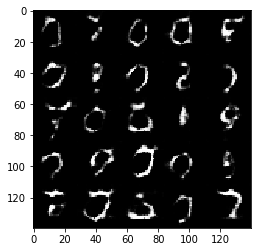

Epoch 1/2... Batch 210... Discriminator Loss: 1.2865... Generator Loss: 1.2041
Epoch 1/2... Batch 220... Discriminator Loss: 1.2512... Generator Loss: 0.9620
Epoch 1/2... Batch 230... Discriminator Loss: 1.4045... Generator Loss: 0.5758
Epoch 1/2... Batch 240... Discriminator Loss: 1.2991... Generator Loss: 0.9372
Epoch 1/2... Batch 250... Discriminator Loss: 1.2687... Generator Loss: 1.0722
Epoch 1/2... Batch 260... Discriminator Loss: 1.2063... Generator Loss: 1.0747
Epoch 1/2... Batch 270... Discriminator Loss: 1.2978... Generator Loss: 0.8634
Epoch 1/2... Batch 280... Discriminator Loss: 1.2944... Generator Loss: 0.8184
Epoch 1/2... Batch 290... Discriminator Loss: 1.3584... Generator Loss: 0.5974
Epoch 1/2... Batch 300... Discriminator Loss: 1.2672... Generator Loss: 0.8311


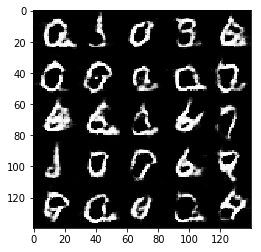

Epoch 1/2... Batch 310... Discriminator Loss: 1.2801... Generator Loss: 0.9182
Epoch 1/2... Batch 320... Discriminator Loss: 1.3000... Generator Loss: 0.8085
Epoch 1/2... Batch 330... Discriminator Loss: 1.3958... Generator Loss: 0.7500
Epoch 1/2... Batch 340... Discriminator Loss: 1.3002... Generator Loss: 0.8667
Epoch 1/2... Batch 350... Discriminator Loss: 1.3088... Generator Loss: 0.7028
Epoch 1/2... Batch 360... Discriminator Loss: 1.3282... Generator Loss: 0.7139
Epoch 1/2... Batch 370... Discriminator Loss: 1.3504... Generator Loss: 0.7887
Epoch 1/2... Batch 380... Discriminator Loss: 1.3277... Generator Loss: 0.9525
Epoch 1/2... Batch 390... Discriminator Loss: 1.3697... Generator Loss: 0.6966
Epoch 1/2... Batch 400... Discriminator Loss: 1.3320... Generator Loss: 0.6491


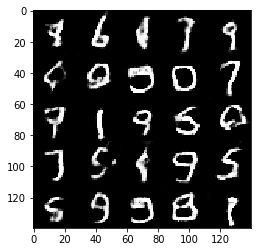

Epoch 1/2... Batch 410... Discriminator Loss: 1.2743... Generator Loss: 0.7879
Epoch 1/2... Batch 420... Discriminator Loss: 1.2565... Generator Loss: 0.8540
Epoch 1/2... Batch 430... Discriminator Loss: 1.4936... Generator Loss: 1.3358
Epoch 1/2... Batch 440... Discriminator Loss: 1.2914... Generator Loss: 0.7630
Epoch 1/2... Batch 450... Discriminator Loss: 1.3106... Generator Loss: 0.9994
Epoch 1/2... Batch 460... Discriminator Loss: 1.2838... Generator Loss: 0.8188
Epoch 1/2... Batch 470... Discriminator Loss: 1.3021... Generator Loss: 0.8922
Epoch 1/2... Batch 480... Discriminator Loss: 1.3319... Generator Loss: 0.7019
Epoch 1/2... Batch 490... Discriminator Loss: 1.3025... Generator Loss: 0.9785
Epoch 1/2... Batch 500... Discriminator Loss: 1.2630... Generator Loss: 0.9817


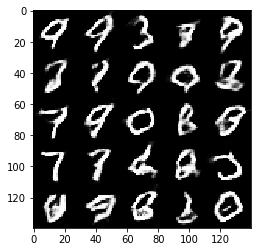

Epoch 1/2... Batch 510... Discriminator Loss: 1.3381... Generator Loss: 1.1102
Epoch 1/2... Batch 520... Discriminator Loss: 1.2733... Generator Loss: 0.8489
Epoch 1/2... Batch 530... Discriminator Loss: 1.3004... Generator Loss: 0.6951
Epoch 1/2... Batch 540... Discriminator Loss: 1.3811... Generator Loss: 0.6022
Epoch 1/2... Batch 550... Discriminator Loss: 1.2972... Generator Loss: 0.8474
Epoch 1/2... Batch 560... Discriminator Loss: 1.3179... Generator Loss: 0.7366
Epoch 1/2... Batch 570... Discriminator Loss: 1.3455... Generator Loss: 0.6596
Epoch 1/2... Batch 580... Discriminator Loss: 1.3782... Generator Loss: 1.3342
Epoch 1/2... Batch 590... Discriminator Loss: 1.2513... Generator Loss: 0.8212
Epoch 1/2... Batch 600... Discriminator Loss: 1.3329... Generator Loss: 0.8271


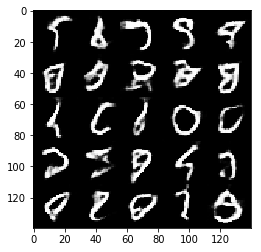

Epoch 1/2... Batch 610... Discriminator Loss: 1.3275... Generator Loss: 0.9839
Epoch 1/2... Batch 620... Discriminator Loss: 1.4495... Generator Loss: 1.3012
Epoch 1/2... Batch 630... Discriminator Loss: 1.2660... Generator Loss: 0.8261
Epoch 1/2... Batch 640... Discriminator Loss: 1.2734... Generator Loss: 0.9304
Epoch 1/2... Batch 650... Discriminator Loss: 1.3371... Generator Loss: 0.6753
Epoch 1/2... Batch 660... Discriminator Loss: 1.3121... Generator Loss: 0.7490
Epoch 1/2... Batch 670... Discriminator Loss: 1.2728... Generator Loss: 0.8128
Epoch 1/2... Batch 680... Discriminator Loss: 1.3465... Generator Loss: 0.6373
Epoch 1/2... Batch 690... Discriminator Loss: 1.3076... Generator Loss: 0.9735
Epoch 1/2... Batch 700... Discriminator Loss: 1.2953... Generator Loss: 0.8402


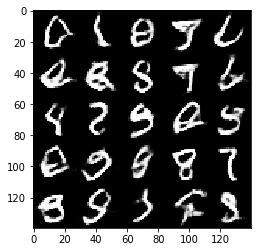

Epoch 1/2... Batch 710... Discriminator Loss: 1.3647... Generator Loss: 0.6132
Epoch 1/2... Batch 720... Discriminator Loss: 1.2752... Generator Loss: 0.9516
Epoch 1/2... Batch 730... Discriminator Loss: 1.3077... Generator Loss: 0.8791
Epoch 1/2... Batch 740... Discriminator Loss: 1.3383... Generator Loss: 1.1797
Epoch 1/2... Batch 750... Discriminator Loss: 1.2664... Generator Loss: 0.9223
Epoch 1/2... Batch 760... Discriminator Loss: 1.2721... Generator Loss: 1.0949
Epoch 1/2... Batch 770... Discriminator Loss: 1.2793... Generator Loss: 0.7839
Epoch 1/2... Batch 780... Discriminator Loss: 1.2873... Generator Loss: 0.7818
Epoch 1/2... Batch 790... Discriminator Loss: 1.3155... Generator Loss: 0.9055
Epoch 1/2... Batch 800... Discriminator Loss: 1.3148... Generator Loss: 0.6766


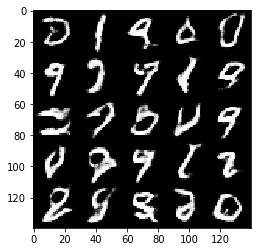

Epoch 1/2... Batch 810... Discriminator Loss: 1.3162... Generator Loss: 0.6909
Epoch 1/2... Batch 820... Discriminator Loss: 1.2803... Generator Loss: 0.7630
Epoch 1/2... Batch 830... Discriminator Loss: 1.2521... Generator Loss: 0.7455
Epoch 1/2... Batch 840... Discriminator Loss: 1.3259... Generator Loss: 0.6101
Epoch 1/2... Batch 850... Discriminator Loss: 1.3550... Generator Loss: 1.2638
Epoch 1/2... Batch 860... Discriminator Loss: 1.4145... Generator Loss: 0.6310
Epoch 1/2... Batch 870... Discriminator Loss: 1.2865... Generator Loss: 0.9551
Epoch 1/2... Batch 880... Discriminator Loss: 1.2748... Generator Loss: 0.8279
Epoch 1/2... Batch 890... Discriminator Loss: 1.3534... Generator Loss: 1.2707
Epoch 1/2... Batch 900... Discriminator Loss: 1.2525... Generator Loss: 0.9322


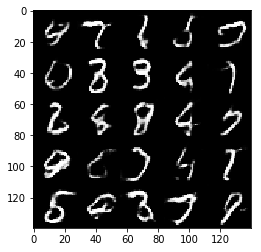

Epoch 1/2... Batch 910... Discriminator Loss: 1.2787... Generator Loss: 0.7971
Epoch 1/2... Batch 920... Discriminator Loss: 1.3068... Generator Loss: 0.6507
Epoch 1/2... Batch 930... Discriminator Loss: 1.2655... Generator Loss: 0.8766


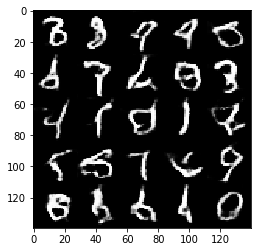

Epoch 2/2... Batch 940... Discriminator Loss: 1.2531... Generator Loss: 0.7961
Epoch 2/2... Batch 950... Discriminator Loss: 1.2687... Generator Loss: 0.9473
Epoch 2/2... Batch 960... Discriminator Loss: 1.2560... Generator Loss: 0.8968
Epoch 2/2... Batch 970... Discriminator Loss: 1.2929... Generator Loss: 1.1528
Epoch 2/2... Batch 980... Discriminator Loss: 1.2904... Generator Loss: 0.8118
Epoch 2/2... Batch 990... Discriminator Loss: 1.3166... Generator Loss: 0.9784
Epoch 2/2... Batch 1000... Discriminator Loss: 1.2960... Generator Loss: 0.9366


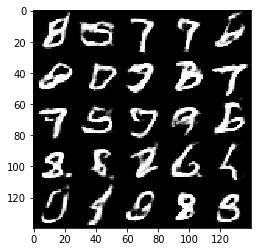

Epoch 2/2... Batch 1010... Discriminator Loss: 1.2973... Generator Loss: 0.7759
Epoch 2/2... Batch 1020... Discriminator Loss: 1.2786... Generator Loss: 0.8476
Epoch 2/2... Batch 1030... Discriminator Loss: 1.2541... Generator Loss: 0.7115
Epoch 2/2... Batch 1040... Discriminator Loss: 1.2910... Generator Loss: 0.7843
Epoch 2/2... Batch 1050... Discriminator Loss: 1.2416... Generator Loss: 0.9321
Epoch 2/2... Batch 1060... Discriminator Loss: 1.3509... Generator Loss: 1.0662
Epoch 2/2... Batch 1070... Discriminator Loss: 1.2848... Generator Loss: 0.9244
Epoch 2/2... Batch 1080... Discriminator Loss: 1.2852... Generator Loss: 0.8545
Epoch 2/2... Batch 1090... Discriminator Loss: 1.3807... Generator Loss: 0.5702
Epoch 2/2... Batch 1100... Discriminator Loss: 1.2942... Generator Loss: 1.1354


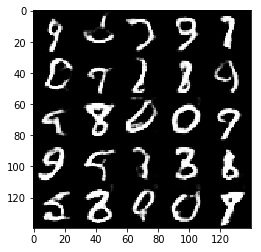

Epoch 2/2... Batch 1110... Discriminator Loss: 1.2780... Generator Loss: 1.0770
Epoch 2/2... Batch 1120... Discriminator Loss: 1.2840... Generator Loss: 0.8492
Epoch 2/2... Batch 1130... Discriminator Loss: 1.2920... Generator Loss: 1.1612
Epoch 2/2... Batch 1140... Discriminator Loss: 1.2295... Generator Loss: 0.9809
Epoch 2/2... Batch 1150... Discriminator Loss: 1.3139... Generator Loss: 0.6724
Epoch 2/2... Batch 1160... Discriminator Loss: 1.3453... Generator Loss: 0.6772
Epoch 2/2... Batch 1170... Discriminator Loss: 1.3164... Generator Loss: 0.9089
Epoch 2/2... Batch 1180... Discriminator Loss: 1.3171... Generator Loss: 0.6768
Epoch 2/2... Batch 1190... Discriminator Loss: 1.3029... Generator Loss: 0.6782
Epoch 2/2... Batch 1200... Discriminator Loss: 1.2953... Generator Loss: 0.6436


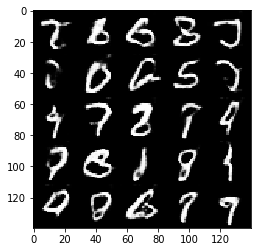

Epoch 2/2... Batch 1210... Discriminator Loss: 1.2673... Generator Loss: 0.8973
Epoch 2/2... Batch 1220... Discriminator Loss: 1.2782... Generator Loss: 0.9872
Epoch 2/2... Batch 1230... Discriminator Loss: 1.2569... Generator Loss: 0.8140
Epoch 2/2... Batch 1240... Discriminator Loss: 1.2308... Generator Loss: 0.8169
Epoch 2/2... Batch 1250... Discriminator Loss: 1.2824... Generator Loss: 0.7102
Epoch 2/2... Batch 1260... Discriminator Loss: 1.2896... Generator Loss: 0.9627
Epoch 2/2... Batch 1270... Discriminator Loss: 1.2843... Generator Loss: 0.9327
Epoch 2/2... Batch 1280... Discriminator Loss: 1.3773... Generator Loss: 1.1247
Epoch 2/2... Batch 1290... Discriminator Loss: 1.2808... Generator Loss: 0.9964
Epoch 2/2... Batch 1300... Discriminator Loss: 1.3321... Generator Loss: 1.1688


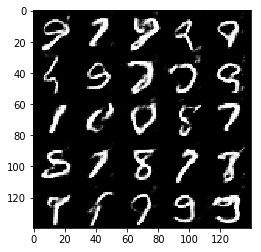

Epoch 2/2... Batch 1310... Discriminator Loss: 1.2776... Generator Loss: 0.9717
Epoch 2/2... Batch 1320... Discriminator Loss: 1.3248... Generator Loss: 0.9220
Epoch 2/2... Batch 1330... Discriminator Loss: 1.5020... Generator Loss: 1.1440
Epoch 2/2... Batch 1340... Discriminator Loss: 1.3158... Generator Loss: 1.0576
Epoch 2/2... Batch 1350... Discriminator Loss: 1.2901... Generator Loss: 0.8172
Epoch 2/2... Batch 1360... Discriminator Loss: 1.2891... Generator Loss: 0.7832
Epoch 2/2... Batch 1370... Discriminator Loss: 1.3198... Generator Loss: 0.7726
Epoch 2/2... Batch 1380... Discriminator Loss: 1.2981... Generator Loss: 0.8895
Epoch 2/2... Batch 1390... Discriminator Loss: 1.2992... Generator Loss: 1.1502
Epoch 2/2... Batch 1400... Discriminator Loss: 1.2721... Generator Loss: 0.7876


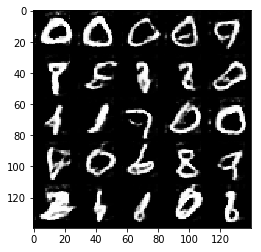

Epoch 2/2... Batch 1410... Discriminator Loss: 1.2690... Generator Loss: 0.8264
Epoch 2/2... Batch 1420... Discriminator Loss: 1.2659... Generator Loss: 1.0402
Epoch 2/2... Batch 1430... Discriminator Loss: 1.2905... Generator Loss: 0.9929
Epoch 2/2... Batch 1440... Discriminator Loss: 1.2666... Generator Loss: 0.7786
Epoch 2/2... Batch 1450... Discriminator Loss: 1.3296... Generator Loss: 0.7380
Epoch 2/2... Batch 1460... Discriminator Loss: 1.2752... Generator Loss: 0.8351
Epoch 2/2... Batch 1470... Discriminator Loss: 1.3875... Generator Loss: 0.5278
Epoch 2/2... Batch 1480... Discriminator Loss: 1.2640... Generator Loss: 0.7940
Epoch 2/2... Batch 1490... Discriminator Loss: 1.3177... Generator Loss: 0.7459
Epoch 2/2... Batch 1500... Discriminator Loss: 1.2963... Generator Loss: 0.7833


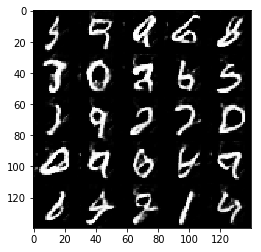

Epoch 2/2... Batch 1510... Discriminator Loss: 1.2524... Generator Loss: 0.7287
Epoch 2/2... Batch 1520... Discriminator Loss: 1.2793... Generator Loss: 0.9232
Epoch 2/2... Batch 1530... Discriminator Loss: 1.3120... Generator Loss: 0.6279
Epoch 2/2... Batch 1540... Discriminator Loss: 1.2730... Generator Loss: 0.7608
Epoch 2/2... Batch 1550... Discriminator Loss: 1.2922... Generator Loss: 0.8256
Epoch 2/2... Batch 1560... Discriminator Loss: 1.2926... Generator Loss: 0.7653
Epoch 2/2... Batch 1570... Discriminator Loss: 1.3494... Generator Loss: 0.9965
Epoch 2/2... Batch 1580... Discriminator Loss: 1.2848... Generator Loss: 0.8624
Epoch 2/2... Batch 1590... Discriminator Loss: 1.2875... Generator Loss: 0.9191
Epoch 2/2... Batch 1600... Discriminator Loss: 1.3750... Generator Loss: 1.0128


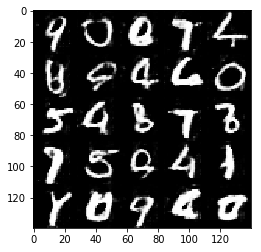

Epoch 2/2... Batch 1610... Discriminator Loss: 1.3762... Generator Loss: 0.7186
Epoch 2/2... Batch 1620... Discriminator Loss: 1.3620... Generator Loss: 0.9012
Epoch 2/2... Batch 1630... Discriminator Loss: 1.3182... Generator Loss: 0.9578
Epoch 2/2... Batch 1640... Discriminator Loss: 1.3289... Generator Loss: 0.8907
Epoch 2/2... Batch 1650... Discriminator Loss: 1.2762... Generator Loss: 0.8917
Epoch 2/2... Batch 1660... Discriminator Loss: 1.4347... Generator Loss: 0.5362
Epoch 2/2... Batch 1670... Discriminator Loss: 1.3362... Generator Loss: 0.7338
Epoch 2/2... Batch 1680... Discriminator Loss: 1.2895... Generator Loss: 0.7956
Epoch 2/2... Batch 1690... Discriminator Loss: 1.3017... Generator Loss: 0.8856
Epoch 2/2... Batch 1700... Discriminator Loss: 1.3004... Generator Loss: 0.8523


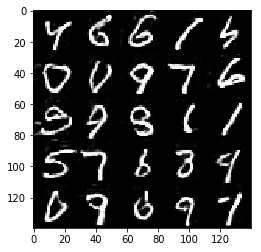

Epoch 2/2... Batch 1710... Discriminator Loss: 1.3674... Generator Loss: 0.6527
Epoch 2/2... Batch 1720... Discriminator Loss: 1.3007... Generator Loss: 0.9791
Epoch 2/2... Batch 1730... Discriminator Loss: 1.3181... Generator Loss: 0.6973
Epoch 2/2... Batch 1740... Discriminator Loss: 1.2907... Generator Loss: 0.9565
Epoch 2/2... Batch 1750... Discriminator Loss: 1.2860... Generator Loss: 0.8120
Epoch 2/2... Batch 1760... Discriminator Loss: 1.2692... Generator Loss: 0.8277
Epoch 2/2... Batch 1770... Discriminator Loss: 1.2851... Generator Loss: 0.7457
Epoch 2/2... Batch 1780... Discriminator Loss: 1.4014... Generator Loss: 0.5755
Epoch 2/2... Batch 1790... Discriminator Loss: 1.3144... Generator Loss: 0.6904
Epoch 2/2... Batch 1800... Discriminator Loss: 1.3726... Generator Loss: 1.0772


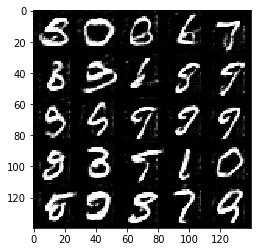

Epoch 2/2... Batch 1810... Discriminator Loss: 1.3591... Generator Loss: 0.8975
Epoch 2/2... Batch 1820... Discriminator Loss: 1.3013... Generator Loss: 0.8501
Epoch 2/2... Batch 1830... Discriminator Loss: 1.2959... Generator Loss: 0.7175
Epoch 2/2... Batch 1840... Discriminator Loss: 1.3745... Generator Loss: 0.7811
Epoch 2/2... Batch 1850... Discriminator Loss: 1.3410... Generator Loss: 0.8079
Epoch 2/2... Batch 1860... Discriminator Loss: 1.2769... Generator Loss: 0.8745
Epoch 2/2... Batch 1870... Discriminator Loss: 1.3145... Generator Loss: 0.7189


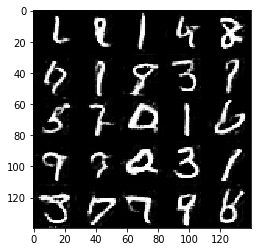

In [13]:
batch_size = 64
z_dim = 50
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.1155... Generator Loss: 0.8563
Epoch 1/1... Batch 20... Discriminator Loss: 1.1693... Generator Loss: 0.8353
Epoch 1/1... Batch 30... Discriminator Loss: 0.9943... Generator Loss: 2.0872
Epoch 1/1... Batch 40... Discriminator Loss: 1.3213... Generator Loss: 4.4303
Epoch 1/1... Batch 50... Discriminator Loss: 0.9986... Generator Loss: 1.6002
Epoch 1/1... Batch 60... Discriminator Loss: 1.0666... Generator Loss: 2.0257
Epoch 1/1... Batch 70... Discriminator Loss: 1.1672... Generator Loss: 0.7364
Epoch 1/1... Batch 80... Discriminator Loss: 0.9979... Generator Loss: 0.9601
Epoch 1/1... Batch 90... Discriminator Loss: 1.0005... Generator Loss: 1.1014
Epoch 1/1... Batch 100... Discriminator Loss: 1.3678... Generator Loss: 0.5228


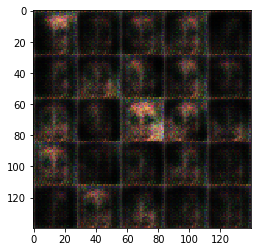

Epoch 1/1... Batch 110... Discriminator Loss: 1.1756... Generator Loss: 0.7503
Epoch 1/1... Batch 120... Discriminator Loss: 1.0073... Generator Loss: 0.9270
Epoch 1/1... Batch 130... Discriminator Loss: 1.0277... Generator Loss: 0.8918
Epoch 1/1... Batch 140... Discriminator Loss: 0.8529... Generator Loss: 1.3384
Epoch 1/1... Batch 150... Discriminator Loss: 0.9974... Generator Loss: 0.9384
Epoch 1/1... Batch 160... Discriminator Loss: 0.9956... Generator Loss: 0.9500
Epoch 1/1... Batch 170... Discriminator Loss: 0.6856... Generator Loss: 2.6701
Epoch 1/1... Batch 180... Discriminator Loss: 0.6759... Generator Loss: 2.6385
Epoch 1/1... Batch 190... Discriminator Loss: 1.1092... Generator Loss: 0.7372
Epoch 1/1... Batch 200... Discriminator Loss: 0.9676... Generator Loss: 0.9186


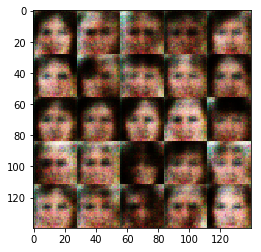

Epoch 1/1... Batch 210... Discriminator Loss: 0.9970... Generator Loss: 0.8431
Epoch 1/1... Batch 220... Discriminator Loss: 1.1040... Generator Loss: 0.7653
Epoch 1/1... Batch 230... Discriminator Loss: 0.6156... Generator Loss: 1.8114
Epoch 1/1... Batch 240... Discriminator Loss: 1.3512... Generator Loss: 0.5042
Epoch 1/1... Batch 250... Discriminator Loss: 0.9122... Generator Loss: 1.0810
Epoch 1/1... Batch 260... Discriminator Loss: 0.9615... Generator Loss: 0.9424
Epoch 1/1... Batch 270... Discriminator Loss: 0.8853... Generator Loss: 1.0870
Epoch 1/1... Batch 280... Discriminator Loss: 0.9365... Generator Loss: 1.2515
Epoch 1/1... Batch 290... Discriminator Loss: 0.7531... Generator Loss: 1.3479
Epoch 1/1... Batch 300... Discriminator Loss: 0.9625... Generator Loss: 0.9651


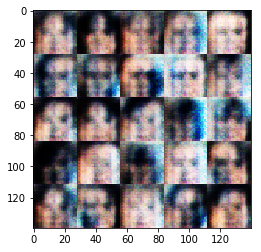

Epoch 1/1... Batch 310... Discriminator Loss: 1.5011... Generator Loss: 4.3667
Epoch 1/1... Batch 320... Discriminator Loss: 0.8254... Generator Loss: 2.9282
Epoch 1/1... Batch 330... Discriminator Loss: 0.6264... Generator Loss: 3.2154
Epoch 1/1... Batch 340... Discriminator Loss: 0.7305... Generator Loss: 1.3876
Epoch 1/1... Batch 350... Discriminator Loss: 0.8966... Generator Loss: 0.9874
Epoch 1/1... Batch 360... Discriminator Loss: 1.1214... Generator Loss: 0.7124
Epoch 1/1... Batch 370... Discriminator Loss: 0.6460... Generator Loss: 1.6224
Epoch 1/1... Batch 380... Discriminator Loss: 0.5964... Generator Loss: 2.8443
Epoch 1/1... Batch 390... Discriminator Loss: 0.6676... Generator Loss: 2.5852
Epoch 1/1... Batch 400... Discriminator Loss: 0.8369... Generator Loss: 3.7498


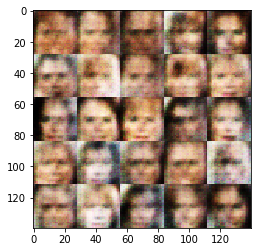

Epoch 1/1... Batch 410... Discriminator Loss: 1.2871... Generator Loss: 2.7304
Epoch 1/1... Batch 420... Discriminator Loss: 0.7840... Generator Loss: 1.3373
Epoch 1/1... Batch 430... Discriminator Loss: 0.8264... Generator Loss: 1.1986
Epoch 1/1... Batch 440... Discriminator Loss: 0.6299... Generator Loss: 1.7205
Epoch 1/1... Batch 450... Discriminator Loss: 0.7743... Generator Loss: 2.2250
Epoch 1/1... Batch 460... Discriminator Loss: 0.7014... Generator Loss: 2.0540
Epoch 1/1... Batch 470... Discriminator Loss: 0.9290... Generator Loss: 2.0845
Epoch 1/1... Batch 480... Discriminator Loss: 0.8958... Generator Loss: 1.0138
Epoch 1/1... Batch 490... Discriminator Loss: 1.1885... Generator Loss: 0.6580
Epoch 1/1... Batch 500... Discriminator Loss: 0.9213... Generator Loss: 0.9551


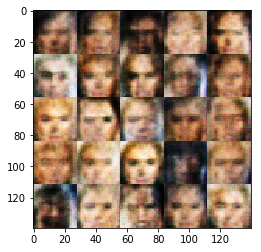

Epoch 1/1... Batch 510... Discriminator Loss: 0.8035... Generator Loss: 1.1744
Epoch 1/1... Batch 520... Discriminator Loss: 1.2385... Generator Loss: 0.5969
Epoch 1/1... Batch 530... Discriminator Loss: 1.3124... Generator Loss: 0.5545
Epoch 1/1... Batch 540... Discriminator Loss: 0.7283... Generator Loss: 1.7548
Epoch 1/1... Batch 550... Discriminator Loss: 0.9453... Generator Loss: 2.2621
Epoch 1/1... Batch 560... Discriminator Loss: 1.0040... Generator Loss: 2.0763
Epoch 1/1... Batch 570... Discriminator Loss: 0.7637... Generator Loss: 1.3410
Epoch 1/1... Batch 580... Discriminator Loss: 0.9401... Generator Loss: 2.8798
Epoch 1/1... Batch 590... Discriminator Loss: 1.3010... Generator Loss: 2.5188
Epoch 1/1... Batch 600... Discriminator Loss: 0.8144... Generator Loss: 2.0961


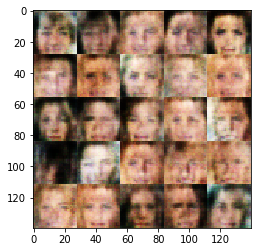

Epoch 1/1... Batch 610... Discriminator Loss: 0.8172... Generator Loss: 2.4889
Epoch 1/1... Batch 620... Discriminator Loss: 0.6905... Generator Loss: 2.3377
Epoch 1/1... Batch 630... Discriminator Loss: 1.3597... Generator Loss: 2.3649
Epoch 1/1... Batch 640... Discriminator Loss: 0.8870... Generator Loss: 1.0890
Epoch 1/1... Batch 650... Discriminator Loss: 0.9335... Generator Loss: 0.9392
Epoch 1/1... Batch 660... Discriminator Loss: 1.2284... Generator Loss: 0.6026
Epoch 1/1... Batch 670... Discriminator Loss: 1.1451... Generator Loss: 0.7267
Epoch 1/1... Batch 680... Discriminator Loss: 1.2479... Generator Loss: 0.6040
Epoch 1/1... Batch 690... Discriminator Loss: 1.3070... Generator Loss: 0.5577
Epoch 1/1... Batch 700... Discriminator Loss: 1.1361... Generator Loss: 0.6960


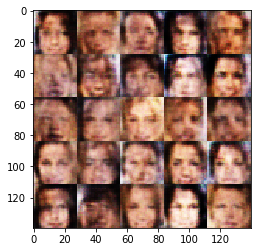

Epoch 1/1... Batch 710... Discriminator Loss: 0.8142... Generator Loss: 1.3282
Epoch 1/1... Batch 720... Discriminator Loss: 1.3254... Generator Loss: 1.8909
Epoch 1/1... Batch 730... Discriminator Loss: 1.2310... Generator Loss: 0.6135
Epoch 1/1... Batch 740... Discriminator Loss: 0.8438... Generator Loss: 1.9892
Epoch 1/1... Batch 750... Discriminator Loss: 0.8377... Generator Loss: 2.9825
Epoch 1/1... Batch 760... Discriminator Loss: 1.1851... Generator Loss: 2.1704
Epoch 1/1... Batch 770... Discriminator Loss: 0.9926... Generator Loss: 1.7130
Epoch 1/1... Batch 780... Discriminator Loss: 0.9932... Generator Loss: 1.7090
Epoch 1/1... Batch 790... Discriminator Loss: 1.1143... Generator Loss: 1.6002
Epoch 1/1... Batch 800... Discriminator Loss: 1.0064... Generator Loss: 1.6429


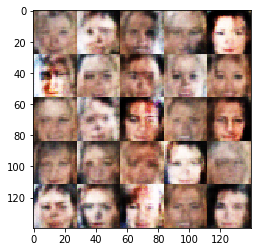

Epoch 1/1... Batch 810... Discriminator Loss: 1.0187... Generator Loss: 1.9046
Epoch 1/1... Batch 820... Discriminator Loss: 0.9022... Generator Loss: 1.8555
Epoch 1/1... Batch 830... Discriminator Loss: 0.9374... Generator Loss: 1.7866
Epoch 1/1... Batch 840... Discriminator Loss: 1.4631... Generator Loss: 2.6517
Epoch 1/1... Batch 850... Discriminator Loss: 1.0301... Generator Loss: 1.0385
Epoch 1/1... Batch 860... Discriminator Loss: 1.6509... Generator Loss: 2.3374
Epoch 1/1... Batch 870... Discriminator Loss: 0.8466... Generator Loss: 1.9866
Epoch 1/1... Batch 880... Discriminator Loss: 0.8259... Generator Loss: 1.6918
Epoch 1/1... Batch 890... Discriminator Loss: 1.0082... Generator Loss: 1.4989
Epoch 1/1... Batch 900... Discriminator Loss: 0.9522... Generator Loss: 1.1540


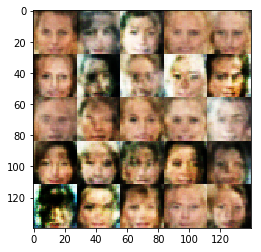

Epoch 1/1... Batch 910... Discriminator Loss: 1.3438... Generator Loss: 0.5458
Epoch 1/1... Batch 920... Discriminator Loss: 0.9014... Generator Loss: 1.1987
Epoch 1/1... Batch 930... Discriminator Loss: 0.9555... Generator Loss: 1.7565
Epoch 1/1... Batch 940... Discriminator Loss: 1.0909... Generator Loss: 1.5996
Epoch 1/1... Batch 950... Discriminator Loss: 1.1000... Generator Loss: 2.0605
Epoch 1/1... Batch 960... Discriminator Loss: 0.9002... Generator Loss: 1.7699
Epoch 1/1... Batch 970... Discriminator Loss: 1.2273... Generator Loss: 1.5386
Epoch 1/1... Batch 980... Discriminator Loss: 1.1176... Generator Loss: 2.2159
Epoch 1/1... Batch 990... Discriminator Loss: 1.0713... Generator Loss: 1.5967
Epoch 1/1... Batch 1000... Discriminator Loss: 1.3693... Generator Loss: 0.5128


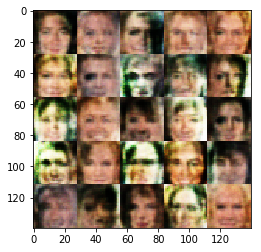

Epoch 1/1... Batch 1010... Discriminator Loss: 1.5625... Generator Loss: 0.3851
Epoch 1/1... Batch 1020... Discriminator Loss: 1.0624... Generator Loss: 0.8355
Epoch 1/1... Batch 1030... Discriminator Loss: 0.9985... Generator Loss: 1.0186
Epoch 1/1... Batch 1040... Discriminator Loss: 1.3604... Generator Loss: 0.5100
Epoch 1/1... Batch 1050... Discriminator Loss: 1.0899... Generator Loss: 0.7991
Epoch 1/1... Batch 1060... Discriminator Loss: 1.0562... Generator Loss: 0.8328
Epoch 1/1... Batch 1070... Discriminator Loss: 1.4222... Generator Loss: 0.4953
Epoch 1/1... Batch 1080... Discriminator Loss: 0.9518... Generator Loss: 1.3950
Epoch 1/1... Batch 1090... Discriminator Loss: 1.2912... Generator Loss: 2.3839
Epoch 1/1... Batch 1100... Discriminator Loss: 0.9048... Generator Loss: 1.9468


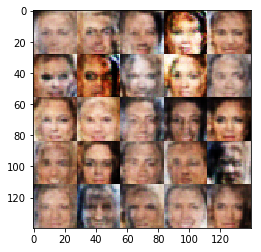

Epoch 1/1... Batch 1110... Discriminator Loss: 0.8995... Generator Loss: 1.8072
Epoch 1/1... Batch 1120... Discriminator Loss: 1.1845... Generator Loss: 2.0936
Epoch 1/1... Batch 1130... Discriminator Loss: 0.9668... Generator Loss: 2.0495
Epoch 1/1... Batch 1140... Discriminator Loss: 1.1006... Generator Loss: 1.4590
Epoch 1/1... Batch 1150... Discriminator Loss: 1.8550... Generator Loss: 0.2793
Epoch 1/1... Batch 1160... Discriminator Loss: 0.9082... Generator Loss: 1.7900
Epoch 1/1... Batch 1170... Discriminator Loss: 0.8996... Generator Loss: 1.6037
Epoch 1/1... Batch 1180... Discriminator Loss: 0.9648... Generator Loss: 1.5371
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1613... Generator Loss: 1.8687
Epoch 1/1... Batch 1200... Discriminator Loss: 0.8360... Generator Loss: 1.9121


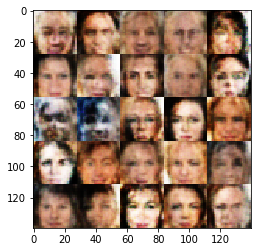

Epoch 1/1... Batch 1210... Discriminator Loss: 0.9384... Generator Loss: 1.9987
Epoch 1/1... Batch 1220... Discriminator Loss: 1.0831... Generator Loss: 1.8691
Epoch 1/1... Batch 1230... Discriminator Loss: 1.2653... Generator Loss: 1.5297
Epoch 1/1... Batch 1240... Discriminator Loss: 1.1230... Generator Loss: 0.9306
Epoch 1/1... Batch 1250... Discriminator Loss: 1.0868... Generator Loss: 0.7921
Epoch 1/1... Batch 1260... Discriminator Loss: 1.0779... Generator Loss: 0.7858
Epoch 1/1... Batch 1270... Discriminator Loss: 0.9137... Generator Loss: 1.3505
Epoch 1/1... Batch 1280... Discriminator Loss: 1.5215... Generator Loss: 0.4282
Epoch 1/1... Batch 1290... Discriminator Loss: 1.2126... Generator Loss: 0.6777
Epoch 1/1... Batch 1300... Discriminator Loss: 0.9302... Generator Loss: 1.0489


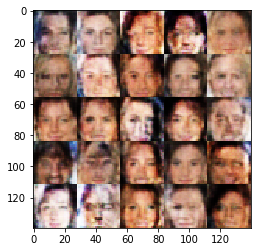

Epoch 1/1... Batch 1310... Discriminator Loss: 1.2424... Generator Loss: 0.5975
Epoch 1/1... Batch 1320... Discriminator Loss: 1.6096... Generator Loss: 0.3598
Epoch 1/1... Batch 1330... Discriminator Loss: 1.1373... Generator Loss: 0.7598
Epoch 1/1... Batch 1340... Discriminator Loss: 1.1551... Generator Loss: 0.6766
Epoch 1/1... Batch 1350... Discriminator Loss: 1.2953... Generator Loss: 0.5653
Epoch 1/1... Batch 1360... Discriminator Loss: 1.0292... Generator Loss: 1.6336
Epoch 1/1... Batch 1370... Discriminator Loss: 1.0727... Generator Loss: 1.9198
Epoch 1/1... Batch 1380... Discriminator Loss: 0.9860... Generator Loss: 1.6231
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8738... Generator Loss: 1.8657
Epoch 1/1... Batch 1400... Discriminator Loss: 1.1387... Generator Loss: 2.2756


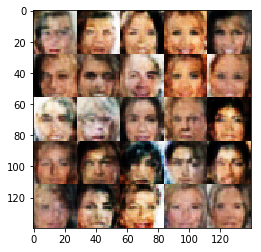

Epoch 1/1... Batch 1410... Discriminator Loss: 0.9722... Generator Loss: 1.0754
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0518... Generator Loss: 0.8628
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2157... Generator Loss: 0.7215
Epoch 1/1... Batch 1440... Discriminator Loss: 1.0756... Generator Loss: 1.5262
Epoch 1/1... Batch 1450... Discriminator Loss: 1.7325... Generator Loss: 1.7381
Epoch 1/1... Batch 1460... Discriminator Loss: 1.0437... Generator Loss: 2.1521
Epoch 1/1... Batch 1470... Discriminator Loss: 1.2848... Generator Loss: 0.5862
Epoch 1/1... Batch 1480... Discriminator Loss: 1.0046... Generator Loss: 0.8741
Epoch 1/1... Batch 1490... Discriminator Loss: 1.5796... Generator Loss: 0.3772
Epoch 1/1... Batch 1500... Discriminator Loss: 1.1537... Generator Loss: 0.6768


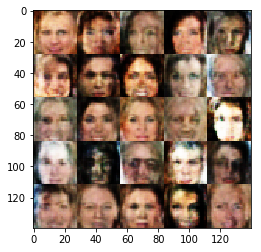

Epoch 1/1... Batch 1510... Discriminator Loss: 1.3327... Generator Loss: 0.5369
Epoch 1/1... Batch 1520... Discriminator Loss: 1.0851... Generator Loss: 1.3046
Epoch 1/1... Batch 1530... Discriminator Loss: 0.9559... Generator Loss: 1.8212
Epoch 1/1... Batch 1540... Discriminator Loss: 1.8840... Generator Loss: 1.6103
Epoch 1/1... Batch 1550... Discriminator Loss: 1.2043... Generator Loss: 1.2361
Epoch 1/1... Batch 1560... Discriminator Loss: 0.9852... Generator Loss: 1.3832
Epoch 1/1... Batch 1570... Discriminator Loss: 1.0054... Generator Loss: 0.9961
Epoch 1/1... Batch 1580... Discriminator Loss: 1.4459... Generator Loss: 0.4535


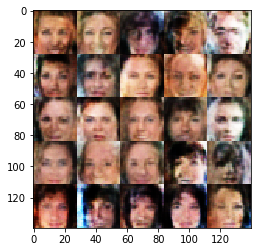

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.